# Knowledge Injection in RL

RL is commonly used in a full **end-to-end** fashion: given an input representation of the problem, the agent is directly trained to provide a solution, without exploiting prior knowledge of the problem. 
When the problem is hard or has an huge actions space, training the agent is expensive or even impossible. 
A notable example is combinatorial optimization: a wide range of combinatorial optimization problems are NP-hard and the solution search space grows exponentially with the size of the problem. This is the reason why they can be a promising use case to evaluate the impact of knowledge injection in RL.

Recently there has been an increasing interest in combining RL with traditional combinatorial optimization methods. The overall idea is to replace hand-designed heuristics, employed in search algorithms, with RL.
An example is https://ojs.aaai.org/index.php/AAAI/article/view/16484 where RL is used as a value-selection heuristic during variables assignments in the search for the solution of Constraint Satisfaction Problems (CSPs).


## Partial Latin Square

We consider the Partial Latin Square (PLS) completion problem which is a well-known CSP with several practical applications.

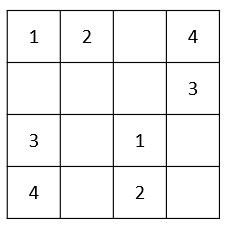

It requires to complete a partially filled $N \times N$ square with all the values in the range $\{ 1,\dots, N \}$ such that no value appears twice on any row or column.

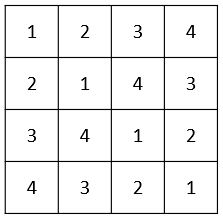

## RL for solving the PLS

We start by training an RL agent to find a solution by filling one cell at time.

We frame the problem as a Markov Decision Process (MDP). An MDP is defined by the tuple $(S, A, R, p, \gamma)$, where $S$ is the set of states, $A$ is the set of actions, $R:S \times A \rightarrow \mathbb{R}$ is the reward function, $p(\cdot | s, a)$ is the probability of leading to a new state by performing action $a$ in state $s$ and $\gamma$ is the discount factor that allows to find a tradeoff between immediate and long-term rewards.

Here the state is the one-hot encoding of the square: if $n$ is the dimension of the PLS, the state $s$ has dimension $n \times n \times n$ where the first dimension represents the row, the second the column and the third the value assigned. An action $a$ consists of assigning a value to a cell (raising a bit in the one-hot encoding representation). The reward is $-1$ for each timestep and $-1000$ if the solution found is infeasible. There may be several viable ways to assign rewards but for one we simply pick this aforementioned.

Let's an example with an agent that performs random actions.

In [1]:
import os
# FIXME: bad code here...
os.chdir('..')

from rl_utils import PLSEnv, RandomAgent, PLSEnv_random_start
from utility import PLSInstance

Create an a simple PLS instance of size $2 \times 2$ and the random agent.

Let's do an episode.

In [2]:
dim = 2
env = PLSEnv(dim=dim)
agent = RandomAgent(num_actions=env.action_space.n, render_actions=True)

In [3]:
done = False

env.reset()
while not done:
    action = agent.act()
    obs, reward, done, info = env.step(action=action)
    env.render()
    
    print(f"feasibile: {info['Feasible']}")
    if info['Solved']:
        print("Solved!")
    
    print('\n' + '-'*100 + '\n')

Row: [1] | Column: [1] | Value: [1]
[[1 0]
 [0 0]]
feasibile: True

----------------------------------------------------------------------------------------------------

Row: [2] | Column: [2] | Value: [1]
[[1 0]
 [0 1]]
feasibile: True

----------------------------------------------------------------------------------------------------

Row: [1] | Column: [1] | Value: [2]
[[1 0]
 [0 1]]
feasibile: False

----------------------------------------------------------------------------------------------------



## First task

As a first task we will train an RL agent to solve the PLS of small size (e.g. $5 \times 5$) in a full end-to-end fashion. A good candidate algorithm is Q-learning since the action space is discrete. There are several open source libraries (e.g. stable-baseline, garage, keras-rl, rl-lib, ...); just pick the one you prefer (or if you like, you can implement Q-learning from scratch but it is not required).

In [4]:
# Imports

# General utilities
import time

# Environment utilities
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.monitor import Monitor

# Neural model definition
import numpy as np
import torch as th
from stable_baselines3 import DQN, A2C

# Visualizations
import pandas as pd
import matplotlib.pyplot as plt

# Model evaluation
from stable_baselines3.common.evaluation import evaluate_policy

In [5]:
# Constants definition
IMG_DPI = 200

In [6]:
# Environment definition
dim = 3
n_rnd_insertions = 2
env = PLSEnv_random_start(dim=dim, n_rnd_insertions=n_rnd_insertions)

In [7]:
# Check the correctness of the environment
check_env(env)

# Wrap the environment in a monitor to track training progress
env = Monitor(env)

In [8]:
# Print some example grids
for i in range(0,3):
    env.reset()
    env.render()
    print()

[[0 0 0]
 [1 3 0]
 [0 0 0]]

[[3 0 0]
 [0 0 2]
 [0 0 0]]

[[0 2 0]
 [0 1 0]
 [0 0 0]]



In [9]:
# Pytorch cuda check
print(th.cuda.is_available())
print(th.cuda.device_count())
print(th.cuda.get_device_name(0))

True
1
NVIDIA GeForce RTX 2060


In [10]:
# DQN network architecture
policy_kwargs = dict(activation_fn=th.nn.ReLU,
                     net_arch=[32, 32],
                     normalize_images=False)


# DQN model definition
model = DQN("MlpPolicy", env, policy_kwargs=policy_kwargs,
            learning_rate=0.001,
            batch_size=512,
            gamma=0.95, #0.9
            exploration_initial_eps=1.0,
            exploration_final_eps=0.05,
            exploration_fraction=0.35, #0.1
            buffer_size=10000, #1000
            learning_starts=10000,
            verbose=1)


print("")
print("Model Architecture:")
print(model.policy)

Using cuda device
Wrapping the env in a DummyVecEnv.

Model Architecture:
DQNPolicy(
  (q_net): QNetwork(
    (features_extractor): FlattenExtractor(
      (flatten): Flatten(start_dim=1, end_dim=-1)
    )
    (q_net): Sequential(
      (0): Linear(in_features=27, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=32, bias=True)
      (3): ReLU()
      (4): Linear(in_features=32, out_features=27, bias=True)
    )
  )
  (q_net_target): QNetwork(
    (features_extractor): FlattenExtractor(
      (flatten): Flatten(start_dim=1, end_dim=-1)
    )
    (q_net): Sequential(
      (0): Linear(in_features=27, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=32, bias=True)
      (3): ReLU()
      (4): Linear(in_features=32, out_features=27, bias=True)
    )
  )
)


In [11]:
# Model Training

start_time = time.time()
model.learn(total_timesteps=400000, log_interval=3000)
print(f"Training time: {(time.time()-start_time)/60} minutes")

#model.save("dqn_model")

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.69     |
|    ep_rew_mean      | -1       |
|    exploration_rate | 0.964    |
| time/               |          |
|    episodes         | 3000     |
|    fps              | 3112     |
|    time_elapsed     | 1        |
|    total_timesteps  | 5295     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.95     |
|    ep_rew_mean      | -1       |
|    exploration_rate | 0.928    |
| time/               |          |
|    episodes         | 6000     |
|    fps              | 1827     |
|    time_elapsed     | 5        |
|    total_timesteps  | 10599    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.147    |
|    n_updates        | 149      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean    

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 6.37     |
|    ep_rew_mean      | 0.48     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 51000    |
|    fps              | 637      |
|    time_elapsed     | 228      |
|    total_timesteps  | 145265   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00827  |
|    n_updates        | 33816    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 6.41     |
|    ep_rew_mean      | 0.42     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 54000    |
|    fps              | 626      |
|    time_elapsed     | 261      |
|    total_timesteps  | 163955   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00521  |
|    n_updates      

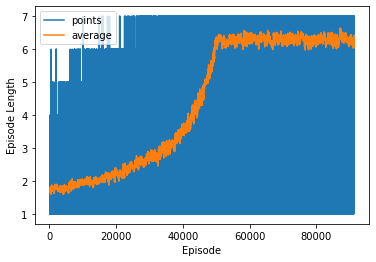

In [12]:
# Apply a smooting average to smooth the time series.
# The function returns both the smoothed time series and the original one, converted into pandas dataframe objects.
def smooth_time_series(points_list, windows_size=3, remove_start_end_nans=True):
    points_list_pd = pd.DataFrame(points_list)
    smoothed_list_pd = points_list_pd.rolling(windows_size, center=True).mean() # Apply moving average
    if remove_start_end_nans:
        return smoothed_list_pd[int(windows_size/2) : -int(windows_size/2)], points_list_pd[int(windows_size/2) : -int(windows_size/2)]
    else:
        return smoothed_list_pd, points_list_pd

    
#env.get_episode_rewards()
#env.get_episode_lengths()

# Plot episodes lentghs during training
sl, pl = smooth_time_series(env.get_episode_lengths(), windows_size=200)
plt.plot(pl, label="points")
plt.plot(sl, label="average")
plt.xlabel("Episode")
plt.ylabel("Episode Length")
plt.legend()
#plt.savefig("dqn_length_3x3.png", dpi=IMG_DPI)
plt.show()

In [13]:
# Obtain the output q_values from the model given an observation and the environment
def get_q_values(model, obs, env):
    cuda0 = th.device('cuda:0')
    obs = th.tensor(obs).to(cuda0)
    obs = obs.reshape((-1,) + env.observation_space.shape)
    return model.policy.q_net(obs)


In [14]:
# Play a game

done = False
n_actions_performed = 0
obs = env.reset()
while not done:
    # Decide action
    action, _states = model.predict(obs, deterministic=True)
    
    print(f"Q-Values: {get_q_values(model, obs, env)}")
    
    # Print selected action
    print(f"action number: {action}")
    row, col, val = np.unravel_index(action, shape=(dim, dim, dim))
    print(f'Row: {row+1} | Column: {col+1} | Value: {val+1}')
    
    # Perform action
    obs, reward, done, info = env.step(action=action)
    env.render()
    n_actions_performed = n_actions_performed + 1
    
    print(f"feasibile: {info['Feasible']}")
    if info['Solved']:
        print("Solved!")
    
    print('\n' + '-'*100 + '\n')

print(f"Number of actions performed: {n_actions_performed}")

Q-Values: tensor([[ 0.5198,  0.0642, -0.7533, -1.5473,  0.8262,  0.6657,  0.3528,  0.1674,
          0.6211,  0.4182,  0.7003, -0.8640, -0.1756, -0.9277, -0.5114, -1.2342,
          0.3433,  0.9528, -1.0749, -0.4457, -0.3650, -0.7596,  0.6697, -0.6663,
          0.8750, -0.0607, -0.8639]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
action number: 17
Row: 2 | Column: 3 | Value: 3
[[0 0 0]
 [0 1 3]
 [3 0 0]]
feasibile: True

----------------------------------------------------------------------------------------------------

Q-Values: tensor([[ 0.5725, -0.5608, -0.9856, -1.6404,  0.2901,  0.8876, -0.2933, -0.0439,
         -0.8958, -0.5138,  0.6963, -1.2688, -0.7240, -0.9469, -1.5671, -1.7232,
         -0.5142, -0.8959, -1.1912, -0.3793, -0.6346, -1.6702,  0.4234, -1.3187,
          0.4289, -0.5313, -1.3509]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
action number: 5
Row: 1 | Column: 2 | Value: 3
[[0 3 0]
 [0 1 3]
 [3 0 0]]
feasibile: True

-------------------------------

In [15]:
# Model Evaluation
n_eval_episodes = 1000
mean_reward, std_reward = evaluate_policy(model, env,
                                          n_eval_episodes=n_eval_episodes,
                                          deterministic=True,
                                          return_episode_rewards=False)
print(f"Mean reward over {n_eval_episodes} episodes: {mean_reward}")
print(f"Standard deviation: {std_reward}")

Mean reward over 1000 episodes: 0.97
Standard deviation: 0.24310491562286438
